## Pair GGL with near-identical deflectors to make PDSPLs

Here we test how changing the magnitude depth of the survey affects the number of PDSPLs discovered.

In [1]:
# Standard imports
import corner
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import pickle

# Astropy imports
from astropy.table import Table

# Lenstronomy, HierArc imports
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from pdspl_analysis_utils import kdtree_matching_n_dim, get_pairs_table_PDSPL, normalize_data
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.style.use("../paper_style.mplstyle")

%load_ext autoreload
%autoreload 2

In [2]:
# FIGURES_DIR = "../figures/"

## Prepare LSST like samples for Single Visit, Y10, and 4MOST 

In [3]:
########################################################
### Load the GGL data table and apply selection cuts!
########################################################

sky_area = "20000.0"
GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')
# GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS_UNIQUE_DEFLECTORS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

# add g-r and r-i colors for deflector
GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

# add log columns
GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

GGL_data_table = GGL_data_table[ 
                                # (GGL_data_table['mag_D_i'] >= 19) & # optional, but reasonable for realistic deflectors
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

GGL_data_table

<Table length=310308>
lens_id        z_D         ... log_Sigma_half_Msun/pc2   log_sigma_v_D   
 int64       float64       ...         float64              float64      
------- ------------------ ... ----------------------- ------------------
      4 0.5499245697508854 ...      3.6421559339150673 2.3444527063774756
      5 0.7607959249289795 ...      3.5797215911271874  2.418350657846043
      6 0.3935362656932773 ...      3.5220928855304434  2.217975781848322
      7 1.8748663580016014 ...        3.87179330290242 2.4252580418749456
     10 1.7871095710166542 ...       3.764669145632392 2.6184066842532845
     13 0.9517425939271492 ...       3.833429428618345  2.578059872711076
     14 0.5675028778691315 ...      3.8180949719107145 2.2329574509716825
     15 1.1039576760380543 ...        4.06634453172709 2.4340946424009484
     18  1.022613379834872 ...       3.725999833381649 2.4215330488372877
    ...                ... ...                     ...                ...
 579757  0.722139254678153 ...      3.4458704069298967  2.373390697847712
 579758 0.9282066843043133 ...       3.603312565933456  2.274860291524616
 579759 0.5511336252011128 ...       3.747086346443124 2.2493669987390383
 579760 0.7728528949749888 ...       4.054162490737135  2.315259775917014
 579761 0.4115682864446375 ...       4.069277918306113 2.4744217449124175
 579762 0.4226634438386093 ...       3.715573811713184 2.2905134235804168
 579763 1.8113373845664227 ...      3.7209982086296614 2.4074127137355203
 579765  1.215964270438903 ...       3.816011410782414  2.400460724450347
 579766 0.8173746912850999 ...      3.7879641375285202 2.3089417157091985
 579767 2.1023254351292744 ...      3.8315922363088926 2.6174125107498956

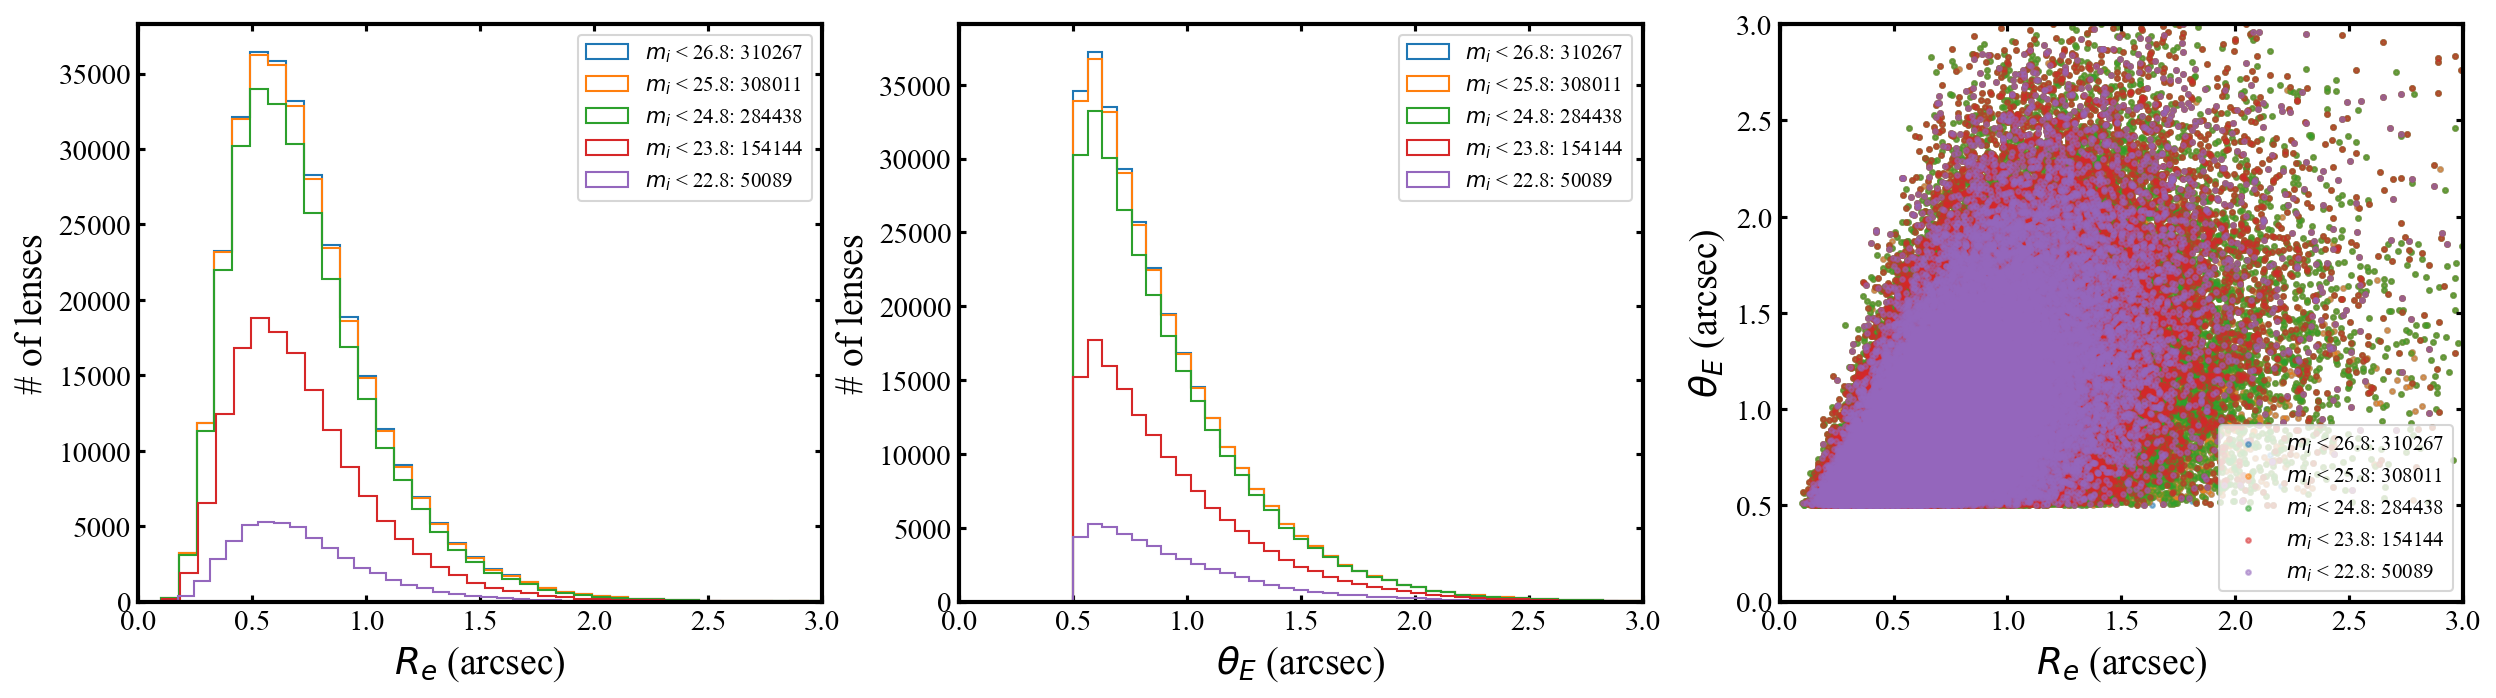

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))



for shallowness in [0, 1, 2, 3, 4]:
    i_depth = 26.8 - shallowness
    depth_mask = (GGL_data_table["mag_D_i"] < i_depth) & (GGL_data_table["mag_S_i_lensed"] < i_depth)
    
    # hist of R_e
    ax[0].hist(
        GGL_data_table['R_e_arcsec'][depth_mask], 
        bins=50,
        histtype='step',    
        label=f"$m_i$ < {i_depth:.1f}: {np.sum(depth_mask)}"
    )

    # hist of theta_E
    ax[1].hist(
        GGL_data_table['theta_E'][depth_mask], 
        bins=50, 
        histtype='step',    
        label=f"$m_i$ < {i_depth:.1f}: {np.sum(depth_mask)}"
    )


    # scatter R_e vs theta_E
    ax[2].scatter(
        GGL_data_table['R_e_arcsec'][depth_mask], 
        GGL_data_table['theta_E'][depth_mask], 
        alpha=0.5, 
        label=f"$m_i$ < {i_depth:.1f}: {np.sum(depth_mask)}",
        s = 5
    )


ax[0].set_xlabel("$R_e$ (arcsec)")
ax[0].set_ylabel("# of lenses")
ax[0].set_xlim(0, 3)

ax[1].set_xlabel("$\\theta_E$ (arcsec)")
ax[1].set_ylabel("# of lenses")
ax[1].set_xlim(0, 3)

ax[2].set_xlabel("$R_e$ (arcsec)")
ax[2].set_ylabel("$\\theta_E$ (arcsec)")
ax[2].set_xlim(0, 3)
ax[2].set_ylim(0, 3)

ax[0].legend()
ax[1].legend()
ax[2].legend()

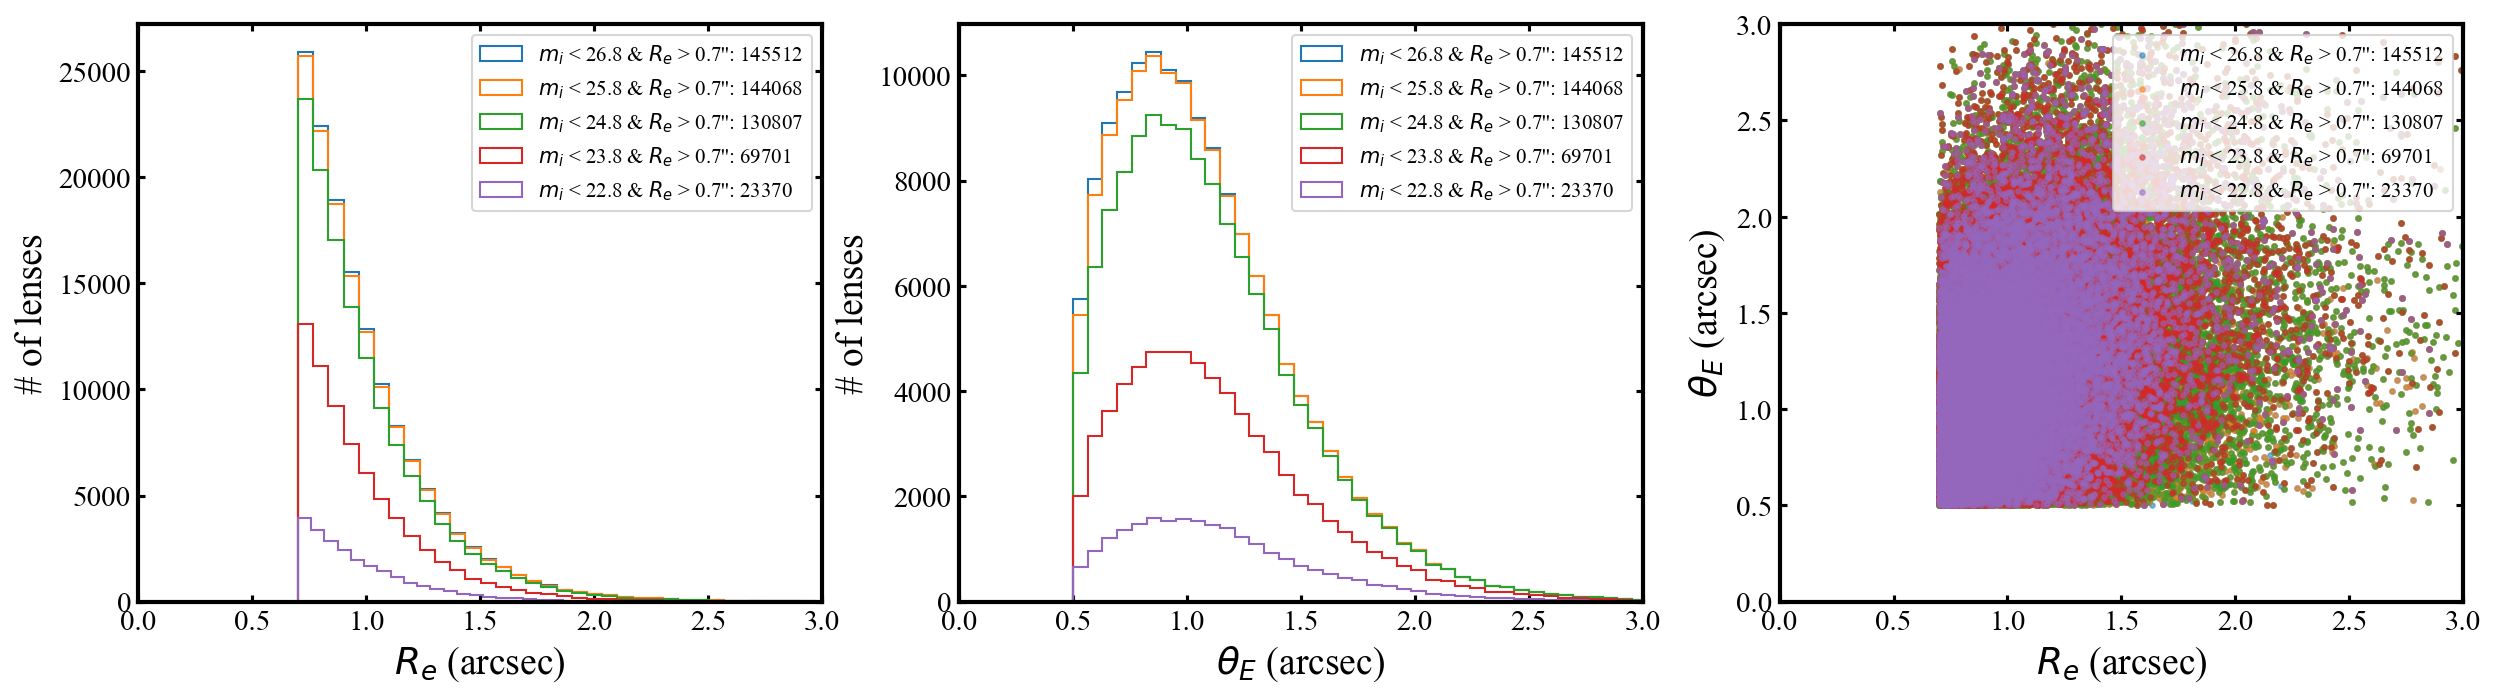

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))



for shallowness in [0, 1, 2, 3, 4]:
    i_depth = 26.8 - shallowness
    depth_mask = (GGL_data_table["mag_D_i"] < i_depth) & (GGL_data_table["mag_S_i_lensed"] < i_depth) & (GGL_data_table["R_e_arcsec"] > 0.7)
    
    # hist of R_e
    ax[0].hist(
        GGL_data_table['R_e_arcsec'][depth_mask], 
        bins=50,
        histtype='step',    
        label=f"$m_i$ < {i_depth:.1f} & $R_e$ > 0.7'': {np.sum(depth_mask)}"
    )

    # hist of theta_E
    ax[1].hist(
        GGL_data_table['theta_E'][depth_mask], 
        bins=50, 
        histtype='step',    
        label=f"$m_i$ < {i_depth:.1f} & $R_e$ > 0.7'': {np.sum(depth_mask)}"
    )


    # scatter R_e vs theta_E
    ax[2].scatter(
        GGL_data_table['R_e_arcsec'][depth_mask], 
        GGL_data_table['theta_E'][depth_mask], 
        alpha=0.5, 
        label=f"$m_i$ < {i_depth:.1f} & $R_e$ > 0.7'': {np.sum(depth_mask)}",
        s = 5
    )


ax[0].set_xlabel("$R_e$ (arcsec)")
ax[0].set_ylabel("# of lenses")
ax[0].set_xlim(0, 3)

ax[1].set_xlabel("$\\theta_E$ (arcsec)")
ax[1].set_ylabel("# of lenses")
ax[1].set_xlim(0, 3)

ax[2].set_xlabel("$R_e$ (arcsec)")
ax[2].set_ylabel("$\\theta_E$ (arcsec)")
ax[2].set_xlim(0, 3)
ax[2].set_ylim(0, 3)

ax[0].legend()
ax[1].legend()
ax[2].legend()

/Users/paras/miniconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/paras/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


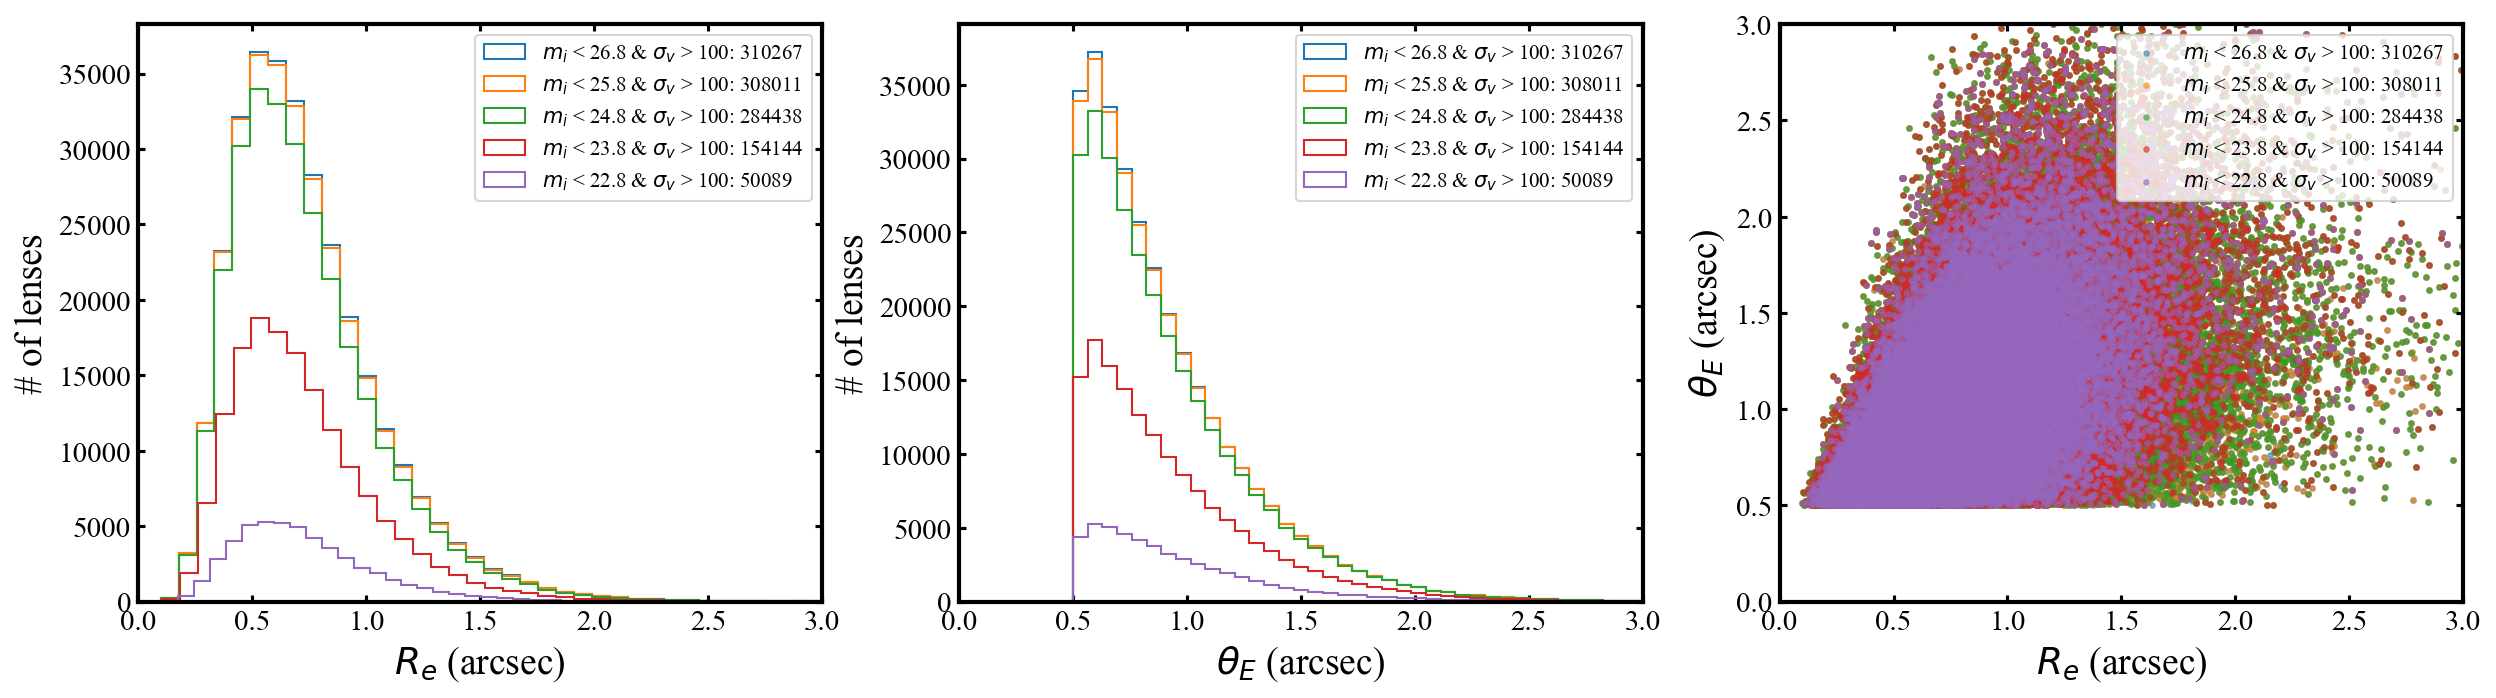

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))



for shallowness in [0, 1, 2, 3, 4]:
    i_depth = 26.8 - shallowness
    depth_mask = (GGL_data_table["mag_D_i"] < i_depth) & (GGL_data_table["mag_S_i_lensed"] < i_depth) & (GGL_data_table["sigma_v_D"] > 100)
    
    # hist of R_e
    ax[0].hist(
        GGL_data_table['R_e_arcsec'][depth_mask], 
        bins=50,
        histtype='step',    
        label=f"$m_i$ < {i_depth:.1f} & $\\sigma_v$ > 100: {np.sum(depth_mask)}"
    )

    # hist of theta_E
    ax[1].hist(
        GGL_data_table['theta_E'][depth_mask], 
        bins=50, 
        histtype='step',    
        label=f"$m_i$ < {i_depth:.1f} & $\\sigma_v$ > 100: {np.sum(depth_mask)}"
    )


    # scatter R_e vs theta_E
    ax[2].scatter(
        GGL_data_table['R_e_arcsec'][depth_mask], 
        GGL_data_table['theta_E'][depth_mask], 
        alpha=0.5, 
        label=f"$m_i$ < {i_depth:.1f} & $\\sigma_v$ > 100: {np.sum(depth_mask)}",
        s = 5
    )


ax[0].set_xlabel("$R_e$ (arcsec)")
ax[0].set_ylabel("# of lenses")
ax[0].set_xlim(0, 3)

ax[1].set_xlabel("$\\theta_E$ (arcsec)")
ax[1].set_ylabel("# of lenses")
ax[1].set_xlim(0, 3)

ax[2].set_xlabel("$R_e$ (arcsec)")
ax[2].set_ylabel("$\\theta_E$ (arcsec)")
ax[2].set_xlim(0, 3)
ax[2].set_ylim(0, 3)

ax[0].legend()
ax[1].legend()
ax[2].legend()

In [26]:
########################################################
### Apply LSST magnitude depth cuts at different levels and produce pdspl_samples
########################################################

pdspl_samples = {}

for shallowness in [0, 1, 2, 3, 4]:
    i_depth = 26.8 - shallowness
    depth_mask = (GGL_data_table["mag_D_i"] < i_depth) & (GGL_data_table["mag_S_i_lensed"] < i_depth) & (GGL_data_table["R_e_arcsec"] > 0.7)
    pdspl_samples[f"depth_{i_depth:.1f}"] = {
        "mask" : depth_mask,
        "title" : f"$m_i$ < {i_depth:.1f} & $R_e$ > 0.7'': {np.sum(depth_mask)}",
        "label" : f"$m_i$ < {i_depth:.1f} & $R_e$ > 0.7''",
        "name" : f"depth_{i_depth:.1f}",
        "color" : f"C{shallowness}",
        "desc" : f"LSST i-band depth cut at {i_depth:.1f} mag with R_e > 0.7''",
        "selc_func_latex" : f"$m_i$ < {i_depth:.1f} & $R_e$ > 0.7''",
        "table": GGL_data_table[depth_mask],
        "count": np.sum(depth_mask)
    }

# Summary
print('-'*80)
print(f"Sky area: {sky_area} deg^2")
print('-'*80)
print(f"SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1\")  # lenses: {len(GGL_data_table)}, # unique deflectors: {len(np.unique(GGL_data_table['z_D']))}")

for key, s in pdspl_samples.items():
    print(f"{s['name']:<62}# lenses: {s['count']:<6}, # unique deflectors: {len(np.unique(s['table']['z_D']))}")

print('-'*80)

--------------------------------------------------------------------------------
Sky area: 20000.0 deg^2
--------------------------------------------------------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1")  # lenses: 310308, # unique deflectors: 283363
depth_26.8                                                    # lenses: 145512, # unique deflectors: 127770
depth_25.8                                                    # lenses: 144068, # unique deflectors: 126347
depth_24.8                                                    # lenses: 130807, # unique deflectors: 114208
depth_23.8                                                    # lenses: 69701 , # unique deflectors: 63098
depth_22.8                                                    # lenses: 23370 , # unique deflectors: 22218
--------------------------------------------------------------------------------


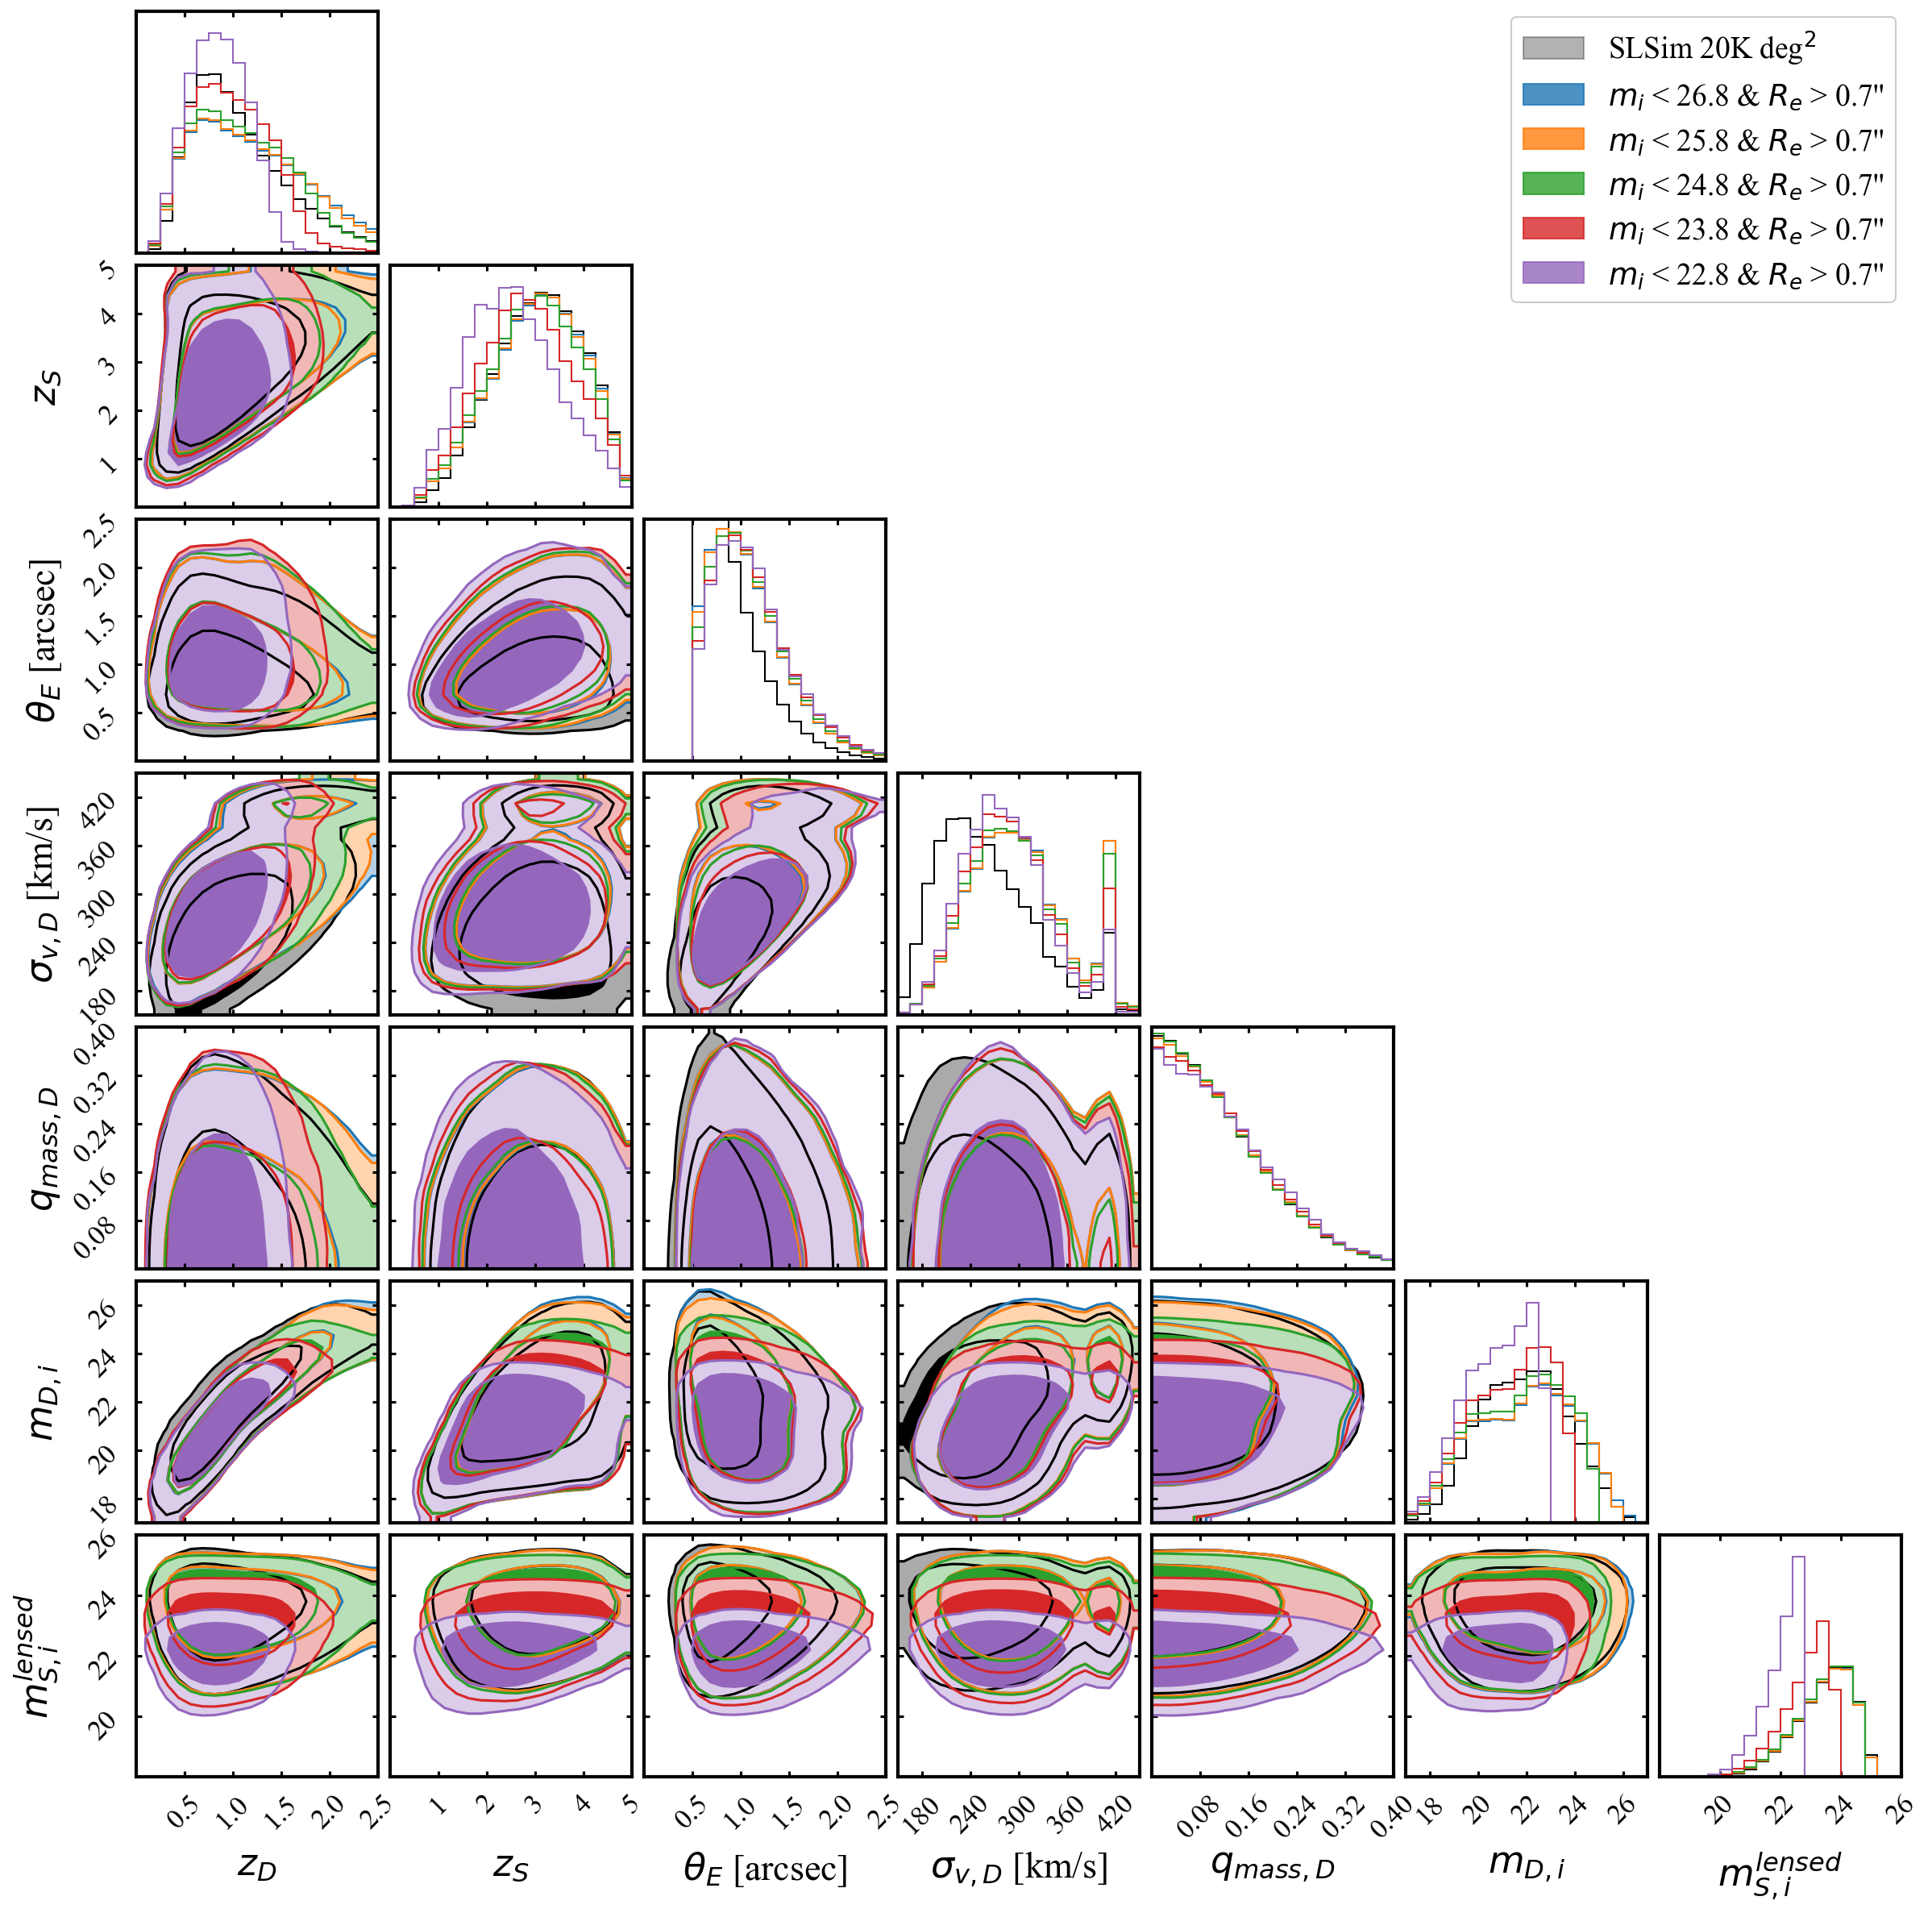

In [28]:
###################################################################
### Make corner plot of the Original and 3 depth cut data sets
###################################################################

samples_to_plot = pdspl_samples.keys()

key_list = ['z_D',
            'z_S',
            'theta_E',
            'sigma_v_D',
            'e_mass_D',
            'mag_D_i', 
            'mag_S_i_lensed']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'theta_E': r'$\theta_E$ [arcsec]',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
    'e_mass_D': r'$q_{mass, D}$',
    'mag_D_i': r'$m_{D, i}$',
    'mag_S_i_lensed': r'$m_{S, i}^{lensed}$',
}

# --- Define plot ranges based on the reference image ---
plot_ranges = [
    (0.0, 2.5),  # z_D
    (0.0, 5.0),  # z_S
    (0.0, 2.5),  # theta_E
    (150, 450),  # sigma_v_D
    (0, 0.4),  # e_mass_D
    (17, 27),    # mag_D_i
    (18, 26)     # mag_S_i_lensed
]


data_corner_ref = [GGL_data_table[key] for key in key_list]
data_corner_ref = np.array(data_corner_ref).T

fig_corner_ref = corner.corner(
    data_corner_ref,
    labels=[key_latex_labels[key] for key in key_list],
    range=plot_ranges, 
    hist_kwargs={"density": True},
    smooth=1,
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.68, 0.95),
);

for sample_key in samples_to_plot:
    data_corner_sample = [pdspl_samples[sample_key]['table'][key] for key in key_list]
    data_corner_sample = np.array(data_corner_sample).T

    corner.corner(
        data_corner_sample,
        labels=[key_latex_labels[key] for key in key_list],
        range=plot_ranges, 
        hist_kwargs={"density": True},
        color=pdspl_samples[sample_key]['color'],
        smooth=1,
        fig=fig_corner_ref,
        plot_datapoints=False,
        fill_contours=True,
        levels=(0.68, 0.95)
    );


# fig_corner_ref.legend(
#     ['SLSim 20000 deg$^2$'] +
#     [pdspl_samples[sample_key]['name'] for sample_key in samples_to_plot],
#     loc='upper right',
#     fontsize=20  # Increased legend font size
# )
legend_handles = []

# 1. Add Reference Handle (Grey Patch)
legend_handles.append(mpatches.Patch(color='black', alpha=0.3, label='SLSim 20K deg$^2$'))
# legend_handles.append(mlines.Line2D([], [], color='black', label='_nolegend_')) # Outline trick

# 2. Add Sample Handles
for sample_key in samples_to_plot:
    color = pdspl_samples[sample_key]['color']
    label = pdspl_samples[sample_key]['label']
    
    # We combine a transparent patch (fill) and a solid line (outline) for the legend
    patch = mpatches.Patch(color=color, alpha=0.8, label=label)
    legend_handles.append(patch)

# Add the legend to the figure (placing it in the upper right empty space)
fig_corner_ref.legend(
    handles=legend_handles,
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98), # Adjust these coordinates to move the box
    fontsize=18,
    frameon=True, 
    facecolor='white',
    framealpha=1.0
)

# make the font size of the labels and titles larger
for ax in fig_corner_ref.get_axes():
    # Increase tick label size and add padding
    ax.tick_params(axis='both', which='major', labelsize=17, pad=8)
    
    # Increase axis label size
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)
    
    # Increase title size (for 1D histograms)
    ax.title.set_size(22)

In [29]:
# --- Cosmology used in SLSim ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [30]:
########################################################
### Pairing Properties and Titles
########################################################

# --- Deflector properties used for pairing ---
keys_to_pair_deflectors = [
    'z_D',
    'R_e_arcsec',
    'mag_D_i',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'R_e_arcsec': r'$R_e$ [arcsec]',
    'mag_D_i': r'$m_i$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
} 

# assign pairing keys for each sample
for key, s in pdspl_samples.items():
    pairing_keys = keys_to_pair_deflectors

    s['pairing_keys'] = pairing_keys
    s['pairing_title'] = "Paired w/ kD-Tree in " + ", ".join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )
    s['pairing_keys_latex'] = ', '.join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )

########################################################
## Adding errors on z_D and sigma_v_D and R_e_arcsec
##########################################################

for sample_key in pdspl_samples.keys():

    # z_D errors
    if sample_key in pdspl_samples.keys():    
        z_D_error = 0.03 * (1 + pdspl_samples[sample_key]['table']['z_D'])  # photometric redshift error from LSST Science Book
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)
    else:
        z_D_error = 0
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D']
    
    # sigma_v_D errors
    sigma_v_error = 0
    sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D']

    # R_e errors => 5-10% error on R_e
    R_e_error = 0.05 * (pdspl_samples[sample_key]['table']['R_e_arcsec'])
    sample_R_e_arcsec_with_errors = pdspl_samples[sample_key]['table']['R_e_arcsec'] + np.random.normal(loc=0, scale=R_e_error)

    # add these errors to a new table
    pdspl_samples[sample_key]['table_with_errors'] = pdspl_samples[sample_key]['table'].copy()
    pdspl_samples[sample_key]['table_with_errors']['z_D'] = sample_z_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['sigma_v_D'] = sample_sigma_v_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['R_e_arcsec'] = sample_R_e_arcsec_with_errors

    pdspl_samples[sample_key]['table_with_errors']['err_z_D'] = z_D_error
    pdspl_samples[sample_key]['table_with_errors']['err_sigma_v_D'] = sigma_v_error
    pdspl_samples[sample_key]['table_with_errors']['err_R_e_arcsec'] = R_e_error

########################################################

########################################################
## define dissimilarity estimator parameters for each sample
##########################################################
# --- Define which parameters to include in the dissimilarity estimator ---
keys_to_use_for_dissimilarity = [
    "rel_diff_R_e_arcsec",
    "rel_diff_z_D",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- (optional) Define pretty LaTeX labels for each key ---
key_latex_map = {
    "rel_diff_R_e_arcsec": r"\frac{\Delta R_e}{R_e}",
    "rel_diff_z_D": r"\frac{\Delta z_D}{z_D}",
    "rel_diff_mag_D_i": r"\frac{\Delta m_i}{m_i}",
    "rel_diff_color_D_gr": r"\frac{\Delta c_{gr}}{c_{gr}}",
    "rel_diff_color_D_ri": r"\frac{\Delta c_{ri}}{c_{ri}}"
}

# assign dissimilarity keys for each sample
for key, s in pdspl_samples.items():
    dissimilarity_keys = keys_to_use_for_dissimilarity

    s['dissimilarity_keys'] = dissimilarity_keys
############################################################

In [31]:
########################################################
###  Get pairs table for each LSST sample
########################################################

for sample_key, s in pdspl_samples.items():
    table = s["table"]

    if len(table) < 2:
        print(f"⚠️ Skipping {sample_key}: too few lenses ({len(table)})")
        continue

    # print(f"\nBuilding full pairs table for {s['name']} ...")

    pairing_keys = s['pairing_keys']
    pairing_title = s['pairing_title']

    # Normalized feature space, use table with errors for pairing
    points = np.stack(
        [normalize_data(s['table_with_errors'][pk], type='zscore') for pk in pairing_keys],
        axis=1
    )

    # Pair with KD-tree
    indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)

    # Build pairs table from kD-tree indices
    pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true)
    pairs_table_with_errors = get_pairs_table_PDSPL(s['table_with_errors'], pair_indices=indices, cosmo=cosmo_true)

    # Compute summary stats
    num_lenses = len(table)
    num_pairs = len(pairs_table)
    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
    scatter_in_beta_E = np.std(1 - beta_ratio)
    mean_beta_ratio = np.mean(beta_ratio)
    median_beta_ratio = np.median(beta_ratio)

    # Store results inside the sample dict
    s["pairs_analysis"] = {
        "pairs_table": pairs_table,
        "pairs_table_with_errors": pairs_table_with_errors,
        "num_lenses": num_lenses,
        "num_pairs": num_pairs,
        "scatter_in_beta_E": scatter_in_beta_E,
        "mean_beta_ratio": mean_beta_ratio,
        "median_beta_ratio": median_beta_ratio,
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
        "pairing_points": points,
    }

    print(f"✅ {s['name']}: {num_pairs} pairs, scatter = {scatter_in_beta_E:.4f}")

########################################################
###  Find dissimilarity estimator for each LSST sample and attach to pairs table
########################################################
for sample_key, s in pdspl_samples.items():
    pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]
    diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
    dissimilarity_estimator = np.sqrt(np.mean(diffs**2, axis=0))
    s["pairs_analysis"]["pairs_table_with_errors"]['dissimilarity'] = dissimilarity_estimator
########################################################

Processing pairs:  32%|███▏      | 33836/107253 [00:04<00:09, 7970.20it/s]WARNING: Second redshift(s) z2 (1.175923530096132) is less than first redshift(s) z1 (1.2488999985335272). [astropy.cosmology._src.flrw.base]
/Users/paras/Projects/PDSPL/pdspl-analysis/pdspl_analysis_utils.py:39: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
Processing pairs: 100%|██████████| 107253/107253 [00:13<00:00, 7950.11it/s]


✅ depth_26.8: 107253 pairs, scatter = 0.1901


Processing pairs: 100%|██████████| 105954/105954 [00:13<00:00, 7903.21it/s]


✅ depth_25.8: 105954 pairs, scatter = 0.1882


Processing pairs: 100%|██████████| 96373/96373 [00:12<00:00, 7856.15it/s]


✅ depth_24.8: 96373 pairs, scatter = 0.1853


Processing pairs: 100%|██████████| 51328/51328 [00:06<00:00, 7838.57it/s]


✅ depth_23.8: 51328 pairs, scatter = 0.1753


Processing pairs:  64%|██████▍   | 11052/17224 [00:01<00:00, 7901.78it/s]WARNING: Second redshift(s) z2 (1.547483912304732) is less than first redshift(s) z1 (1.5555707440006825). [astropy.cosmology._src.flrw.base]
/Users/paras/Projects/PDSPL/pdspl-analysis/pdspl_analysis_utils.py:39: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
Processing pairs: 100%|██████████| 17224/17224 [00:02<00:00, 7862.38it/s]


✅ depth_22.8: 17224 pairs, scatter = 0.1714


depth_26.8: scatter vs dissimilarity fit: slope = 0.254, intercept = -0.348
depth_25.8: scatter vs dissimilarity fit: slope = 0.271, intercept = -0.325
depth_24.8: scatter vs dissimilarity fit: slope = 0.253, intercept = -0.357
depth_23.8: scatter vs dissimilarity fit: slope = 0.226, intercept = -0.424
depth_22.8: scatter vs dissimilarity fit: slope = 0.220, intercept = -0.430


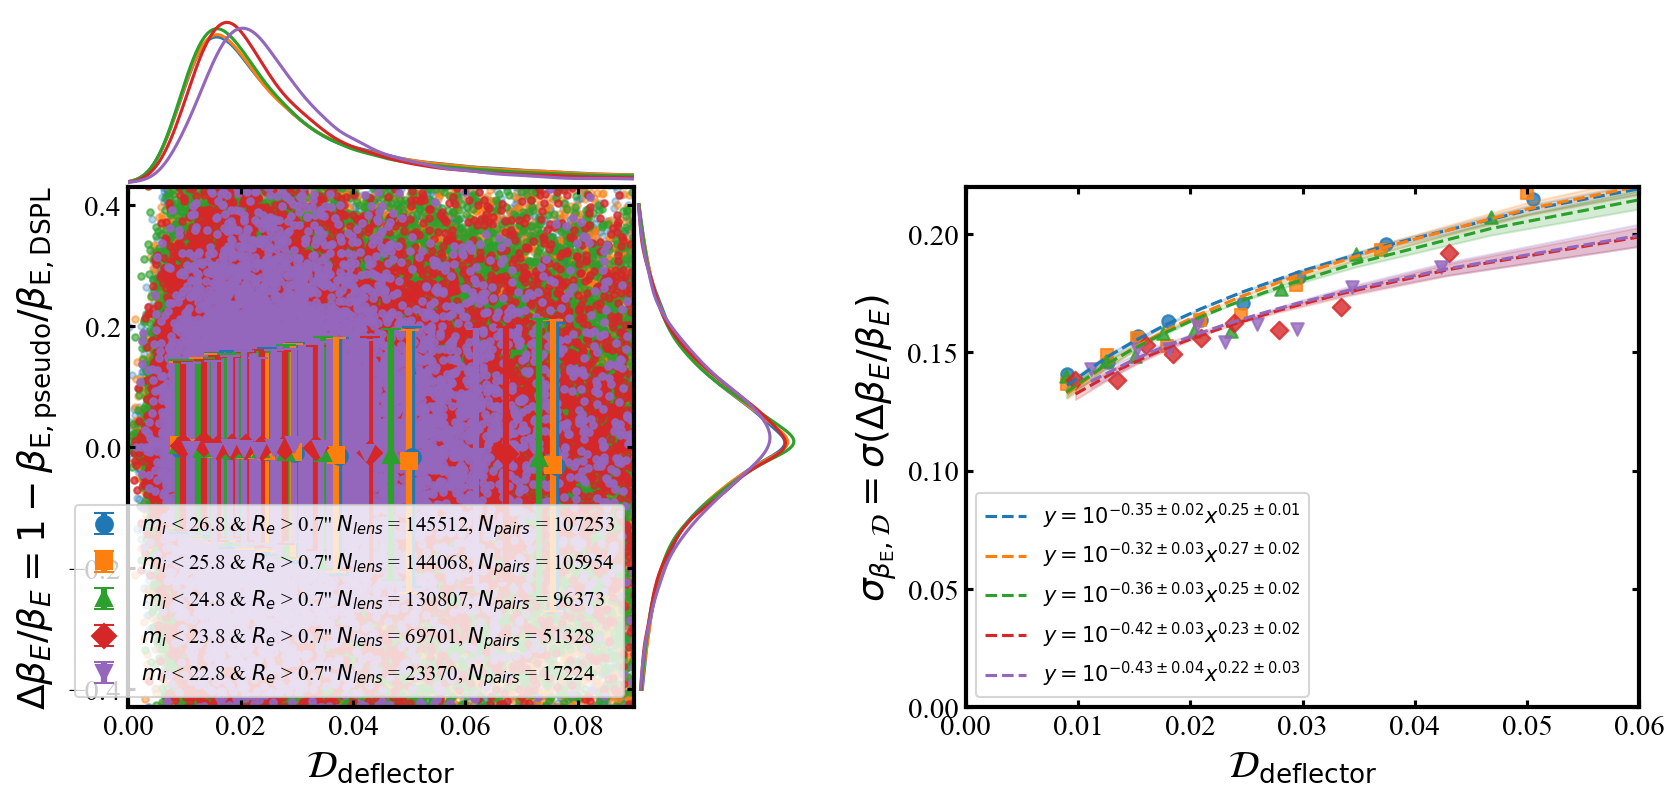

In [37]:
########################################
### scatter_beta_E as a function of dissimilarity
########################################

alpha_vals = {}
markers = {}

for i, sample_key in enumerate(pdspl_samples.keys()):
    alpha_vals[sample_key] = 0.3 + 0.15 * i
    markers[sample_key] = ['o', 's', '^', 'D', 'v'][i]

# --- Set up figure layout
fig = plt.figure(figsize=(13, 6))
gs = GridSpec(4, 9, figure=fig, wspace=-0.02, hspace=-0.02,
              )

ax_scatter = fig.add_subplot(gs[1:, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:, 3], sharey=ax_scatter)
ax_fit = fig.add_subplot(gs[1:, 5:9])

ignore_keys = [
    # 'lsst_4most_spec-z',
    # 'lsst_4most_spec-z_sigma_v'
]

# --- Loop through samples
for sample_key, s in pdspl_samples.items() :
    if sample_key in ignore_keys:
        continue
    tbl_err = s["pairs_analysis"]["pairs_table_with_errors"]
    tbl = s["pairs_analysis"]["pairs_table"]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # limit to dissimilarity < 0.1 for better visualization
    mask = (tbl_err['dissimilarity'] < 0.1) & (np.isfinite(delta_beta_E))
    tbl_err = tbl_err[mask]
    tbl = tbl[mask]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # Scatter
    ax_scatter.scatter(
        dissimilarities,
        delta_beta_E,
        color=s['color'],
        alpha=alpha_vals[sample_key],
        s=10,
    )

    # Histograms
    # ax_histx.hist(dissimilarities, bins=40, color=s['color'], histtype='step',
    #               density=True)
    # ax_histy.hist(delta_beta_E, bins=40, color=s['color'], orientation='horizontal', histtype='step',
    #               density=True)
    
    # --- KDE smoothed histograms
    kde_x = gaussian_kde(dissimilarities)
    kde_y = gaussian_kde(delta_beta_E)
    x_grid = np.linspace(0, 0.1, 200)
    y_grid = np.linspace(-0.4, 0.4, 200)
    ax_histx.plot(x_grid, kde_x(x_grid), color=s['color'], lw=1.5)
    ax_histy.plot(kde_y(y_grid), y_grid, color=s['color'], lw=1.5)

    
    # bin the dissimilarities, using percentiles, use np.digitize to bin
    percentiles = np.percentile(dissimilarities, np.arange(0, 101, 10))
    digitized = np.digitize(dissimilarities, percentiles)

    binned_dissimilarities = []
    binned_scatter_beta_E = []
    binned_means_beta_E = []

    for i in range(1, len(percentiles)):
        bin_mask = digitized == i
        if np.sum(bin_mask) > 0:
            binned_dissimilarities.append(np.median(dissimilarities[bin_mask]))
            scatter_in_beta_E = np.nanstd(delta_beta_E[bin_mask])
            binned_scatter_beta_E.append(scatter_in_beta_E)
            binned_means_beta_E.append(np.nanmean(delta_beta_E[bin_mask]))

    # on the original scatter plot, plot the binned means +- scatter
    ax_scatter.errorbar(
        binned_dissimilarities,
        binned_means_beta_E,
        yerr=binned_scatter_beta_E,
        fmt=markers[sample_key],
        color=s['color'],
        markersize=8,
        # markeredgecolor='k',
        label=s['label'] + " $N_{lens}$ = " + str(s['count']) + f", $N_{{pairs}}$ = {s['pairs_analysis']['num_pairs']}",
        capsize=5,
        elinewidth=3,
    )

    # plot the binned scatter vs binned dissimilarity
    ax_fit.scatter(
        binned_dissimilarities,
        binned_scatter_beta_E,
        marker=markers[sample_key],
        color=s['color'],
        # label=s['name'],
        alpha=0.8,
    )
    
    # fit a line in log-log space, use covariance matrix to get uncertainties
    coeffs, cov = np.polyfit(np.log10(np.array(binned_dissimilarities)), 
                            np.log10(np.array(binned_scatter_beta_E)), 1, cov=True)
    
    # fit equation latex
    fit_eq_latex = r"$y = 10^{%.2f \pm %.2f} x^{%.2f \pm %.2f}$" % (
        coeffs[1], np.sqrt(cov[1, 1]),
        coeffs[0], np.sqrt(cov[0, 0])
    )

    # fitted line and 1-sigma uncertainty region
    ax_fit.plot(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs, np.log10(np.array(binned_dissimilarities)))),
        linestyle='--',
        color=s['color'],
        label = fit_eq_latex
    )
    ax_fit.fill_between(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs - np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        10**(np.polyval(coeffs + np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        color=s['color'],
        alpha=0.2,
    )

    # attach the fitted coeffs to the sample dict
    s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs'] = coeffs
    s['pairs_analysis']['scatter_vs_dissimilarity_fit_cov'] = cov

    # print the fit results
    print(f"{s['name']}: scatter vs dissimilarity fit: slope = {coeffs[0]:.3f}, intercept = {coeffs[1]:.3f}")
    

# --- Labels, limits, etc.
ax_scatter.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_scatter.set_ylabel(r"$\Delta \beta_{E} / \beta_{E} = 1 - \beta_{\rm E, pseudo}/\beta_{\rm E, DSPL}$")
ax_scatter.set_xlim(0, 0.09)
ax_scatter.set_ylim(-0.43, 0.43)
ax_scatter.legend(frameon=True)

# --- Hide axis for the marginal histograms
ax_histx.axis('off')
ax_histy.axis('off')


# --- Fit panel axis labels
ax_fit.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_fit.set_ylabel(r"$\sigma_{\beta_{\rm E},\rm \mathcal{D}} = \sigma(\Delta \beta_{E} / \beta_{E})$")
ax_fit.set_xlim(0, 0.06)
ax_fit.set_ylim(0, 0.22)
ax_fit.legend(frameon=True)


# --- Save figure
